In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import Activation, Input, Conv2D, Add, Flatten, AveragePooling2D, Dense, Dropout, BatchNormalization
from keras.utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
import h5py

Using TensorFlow backend.


In [2]:
train = pd.read_csv("../input/digit-recognizer/train.csv")
test = pd.read_csv("../input/digit-recognizer/test.csv")
sample = pd.read_csv("../input/digit-recognizer/sample_submission.csv")

In [3]:
train.describe()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,42000.000000,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,...,42000.000000,42000.000000,42000.000000,42000.00000,42000.000000,42000.000000,42000.0,42000.0,42000.0,42000.0
mean,4.456643,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.219286,0.117095,0.059024,0.02019,0.017238,0.002857,0.0,0.0,0.0,0.0
std,2.887730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.312890,4.633819,3.274488,1.75987,1.894498,0.414264,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,7.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,9.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254.000000,254.000000,253.000000,253.00000,254.000000,62.000000,0.0,0.0,0.0,0.0


In [4]:
X = train.drop("label", axis = 1).values.reshape(-1, 28, 28, 1)
y = train["label"].values

test = test.values.reshape(-1, 28, 28, 1)

def normalize(data):
    return (data/255)

X = normalize(X)
test = normalize(test) 

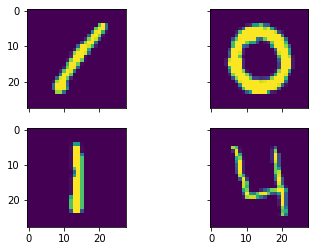

In [5]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex = True, sharey = True)
axs = [ax1, ax2, ax3, ax4]
for i in range(len(axs)):
    axs[i].imshow(X[i][:, :, 0])

# Resnet Architecture

Resnets (Residual Networks) are used when we need to train very deep neural networks. Because we know weights updation during back propagation follows chain rule, if netweek is very deep then there is a chance of vanishing gradient which makes weight updation slow which makes learning very slow. To avoid this we use residual network. Below is the architecture of Resnet.

Here is a [link](https://en.wikipedia.org/wiki/Vanishing_gradient_problem) for Vanishing Gradient

![](https://miro.medium.com/max/1226/1*zS2ChIMwAqC5DQbL5yD9iQ.png)

# Building our own Resnet

In [6]:
def blocks(x, strides, filters):
    y = x
    
    x = Conv2D(filters, kernel_size = 3, padding = "same", strides = strides)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    x = Conv2D(filters, kernel_size = 3, padding = "same", strides = (1, 1))(x)
    x = BatchNormalization()(x)
    
    
    if strides[0] > 1:
        y = Conv2D(filters, kernel_size = 3, padding = "same", strides = strides)(y)
        y = BatchNormalization()(y)
        
    x = Add()([x, y])
    return x

In [7]:
def residual_net(input_shape, num_classes, filters, blks):
    inputs = Input(input_shape)
    x = Conv2D(filters, kernel_size = 7, padding = "same", strides = (1, 1))(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    # Adding residual blocks
    for block in blks:
        x = blocks(x, strides = (2, 2), filters = filters)
        for i in range(block - 1):
            x = blocks(x, strides = (1, 1), filters = filters)
        filters *= 2
        
    x = AveragePooling2D(4)(x)
    x = Flatten()(x)
    x = Dropout(0.3)(x)
    x = Dense(int(filters/4), activation='relu')(x)
    outputs = Dense(10, activation='softmax')(x)
    
    # Instantiate model
    model = Model(inputs=inputs, outputs=outputs)
    return model       
        

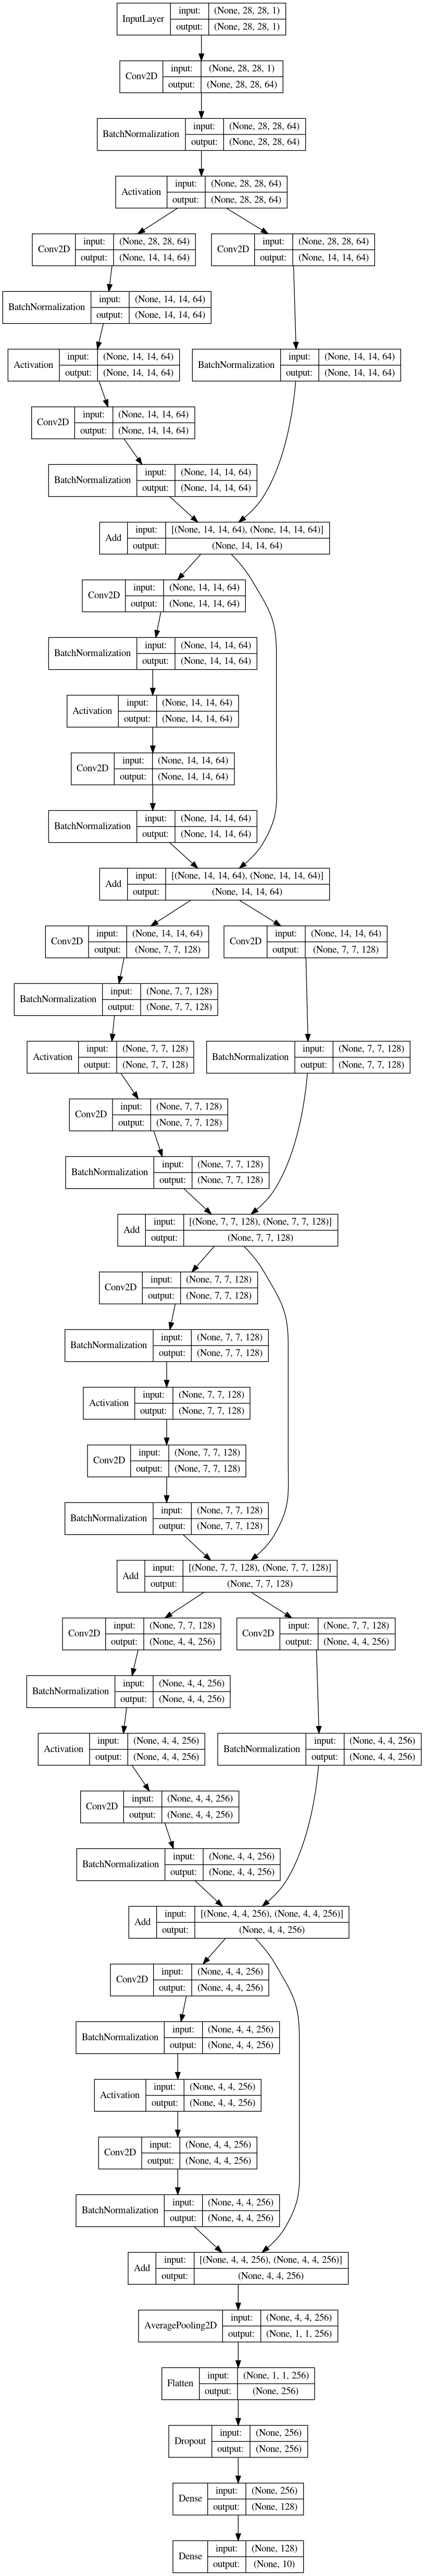

In [8]:
model = residual_net(
    input_shape=X[0].shape, 
    num_classes=np.unique(y).shape[-1], 
    filters=64, 
    blks=[2,2,2]
)
resnet_architecture = plot_model(model, show_shapes=True, show_layer_names=False)
resnet_architecture.width = 600
resnet_architecture

In [9]:
def train(epochs, batch_size, i):
    model = residual_net(
    input_shape=X[0].shape, 
    num_classes=np.unique(y).shape[-1], 
    filters=64, 
    blks=[3,3,3])
    
    model.compile(loss = "sparse_categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])
    
    checkpoint = ModelCheckpoint(
    filepath=f'resnet-{i}.hdf5',
    monitor='loss',
    save_best_only=True
    )
    def scheduler(epoch):
        return 0.001 * 0.8**epoch
    schedule = LearningRateScheduler(scheduler)
    callbacks = [checkpoint, schedule]
    
    train_datagen = ImageDataGenerator(  
        rotation_range=10,  
        zoom_range=0.1, 
        width_shift_range=0.1, 
        height_shift_range=0.1)
    
    train_datagen.fit(X)

    # Fit model
    history = model.fit_generator(
        train_datagen.flow(X, y, batch_size=batch_size),
        epochs=epochs, 
        verbose=2, 
        callbacks=callbacks)
    
    return history, model
    
    
    

In [10]:
models = []
all_history = []
for i in range(5):
    print("#"*20)
    print(f"Model number {i + 1}")
    print("#"*20)
    
    history, model = train(
        epochs=12,
        batch_size=128, i = i)
    
    models.append(model)
    all_history.append(history)

####################
Model number 1
####################
Epoch 1/12
 - 33s - loss: 0.2269 - accuracy: 0.9287
Epoch 2/12
 - 25s - loss: 0.0749 - accuracy: 0.9764
Epoch 3/12
 - 24s - loss: 0.0553 - accuracy: 0.9834
Epoch 4/12
 - 23s - loss: 0.0415 - accuracy: 0.9870
Epoch 5/12
 - 23s - loss: 0.0358 - accuracy: 0.9891
Epoch 6/12
 - 22s - loss: 0.0330 - accuracy: 0.9901
Epoch 7/12
 - 23s - loss: 0.0251 - accuracy: 0.9920
Epoch 8/12
 - 23s - loss: 0.0229 - accuracy: 0.9929
Epoch 9/12
 - 22s - loss: 0.0221 - accuracy: 0.9936
Epoch 10/12
 - 23s - loss: 0.0184 - accuracy: 0.9943
Epoch 11/12
 - 22s - loss: 0.0162 - accuracy: 0.9948
Epoch 12/12
 - 23s - loss: 0.0145 - accuracy: 0.9954
####################
Model number 2
####################
Epoch 1/12
 - 27s - loss: 0.2340 - accuracy: 0.9259
Epoch 2/12
 - 22s - loss: 0.0733 - accuracy: 0.9776
Epoch 3/12
 - 21s - loss: 0.0548 - accuracy: 0.9839
Epoch 4/12
 - 21s - loss: 0.0479 - accuracy: 0.9855
Epoch 5/12
 - 22s - loss: 0.0350 - accuracy: 0.9893

In [11]:
preds = []
for model in models:
    preds.append(model.predict(test))
    

In [13]:
f_pred = np.zeros(preds[0].shape)
for p in preds:
    f_pred = f_pred + p
    
preds_mean = (f_pred)/5

In [14]:
predictions = np.argmax(preds_mean, axis=1)

In [15]:
result = pd.Series(predictions, name = "Label")
sample["Label"] = result
sample.set_index("ImageId", inplace = True)
sample.to_csv("submission_resnet.csv")